In [1]:
# import necessary packages
import os
import numpy as np
import tkinter as tk
from tkinter import filedialog
import cv2
import pickle
from scipy.stats import median_abs_deviation

import bm3d

ModuleNotFoundError: No module named 'bm3d'

In [ ]:
image_dir = filedialog.askdirectory()
mask_dir = filedialog.askdirectory()

print(image_dir)
print(mask_dir)

C:/Users/ssztr/SandBox/MachineLearning/RoyerLab/BacterialSegmentation/Data/MG1655/Images
C:/Users/ssztr/SandBox/MachineLearning/RoyerLab/BacterialSegmentation/Data/MG1655/Masks


In [ ]:
# get files, create file pairs given that "mask_" prepends image filename
img_names = os.listdir(image_dir)
msk_names = os.listdir(mask_dir)

def pair_files(image_files, mask_files, mask_prefix="mask_"):
    """Pair data files with corresponding mask files based on name matching."""
    file_pairs = []

    # Create a lookup dictionary for mask files without the prefix
    mask_dict = {f[len(mask_prefix):-len(f.split('.')[-1])-1]: f for f in mask_files if f.startswith(mask_prefix)}
    for image_file in image_files:
        image_key = image_file[:-len(image_file.split('.')[-1])-1]
        mask_file = mask_dict.get(image_key)
        if mask_file:
            file_pairs.append({"image_name": image_file, "mask_name": mask_file})

    return file_pairs

file_pairs = pair_files(image_files=img_names, mask_files=msk_names)

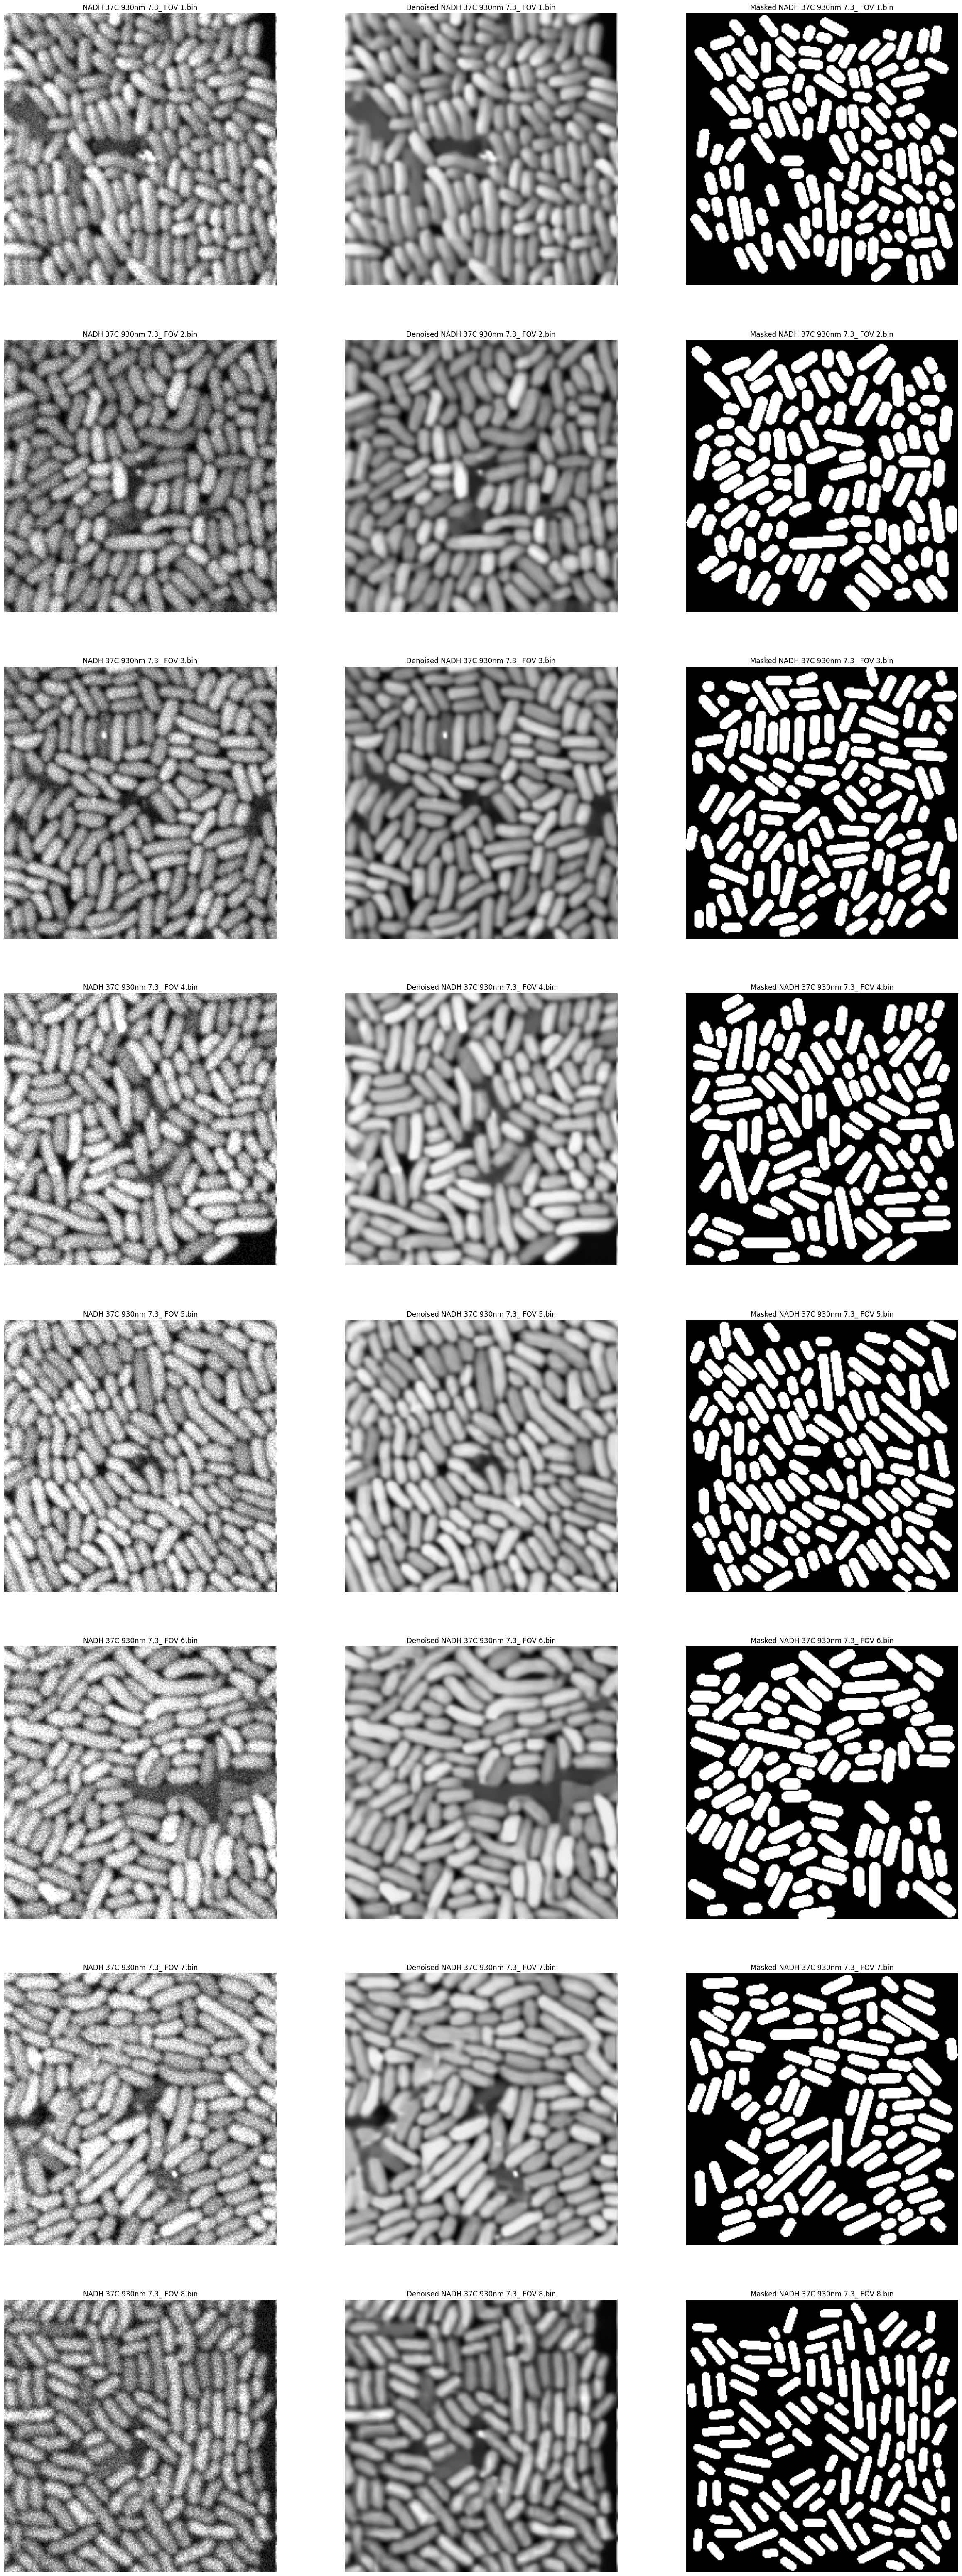

In [ ]:
npix = 256

def load_image(image_name, image_dir):
    """Load image data and convert to np.ndarray[256, 256] of stack-wise average"""
    with open(os.path.join(image_dir, image_name)) as f:
        data = np.fromfile(f, dtype=np.float16)

    n_scans = data.size // (npix**2)
    data = data.reshape((n_scans, npix, npix))

    image = np.mean(data, axis=0).T
    if np.isnan(image).any() or np.isinf(image).any():
        print(f"Image Name: {image_name}")
        print("Any NaNs?", np.isnan(data).any())  # Should be False
        print("Any Infs?", np.isinf(data).any())  # Should be False

    return image

def load_mask(mask_name, mask_dir):
    """Load mask data and convert to binary np.ndarray[256, 256]"""

    mask = cv2.imread(os.path.join(mask_dir, mask_name))
    mask = np.mean(mask, axis=2)
    if np.isnan(mask).any() or np.isinf(mask).any():
        print(f"Mask Name: {mask_name}")
        print("Any NaNs?", np.isnan(mask).any())  # Should be False
        print("Any Infs?", np.isinf(mask).any())  # Should be False
    return mask

import matplotlib.pyplot as plt

# Load images and masks into numpy arrays
num_pairs = len(file_pairs)
fig, axes = plt.subplots(num_pairs, 3, figsize=(30, num_pairs*10))

images_data = np.zeros((num_pairs, npix, npix))
masks_data = np.zeros((num_pairs, npix, npix))

for i in range(0, num_pairs):
    pair = file_pairs[i]

    image = load_image(image_name=pair["image_name"], image_dir=image_dir).astype(np.float64)
    mask = load_mask(mask_name=pair["mask_name"], mask_dir=mask_dir)

    # calculate thresholds to remove absurd pixel values - helps to remove bursts, could also just exclude burst-containing images...
    cell_pixels = image[mask != 0]
    med = np.median(cell_pixels)
    mad = median_abs_deviation(cell_pixels)
    threshold = med + mad*3
    image[image > threshold] = threshold

    # Normalize data: mean = 0, std = 1
    image = (image - np.mean(image)) / np.std(image)

    image_denoised = bm3d.bm3d(image, sigma_psd=0.75)

    images_data[i] = image_denoised
    masks_data[i] = mask


    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(pair["image_name"])

    axes[i, 1].imshow(image_denoised, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title("Denoised " + pair["image_name"])

    axes[i, 2].imshow(mask, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Masked " + pair["image_name"])

In [ ]:
# Select output directory and create "ProcessedData" folder for outputs
output_directory_path = filedialog.askdirectory()

output_directory = os.path.join(output_directory_path, "MG1655Processed")

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

with open(os.path.join(output_directory, "data.pkl"), 'wb') as f:
    pickle.dump((images_data, masks_data), f)



Confirming data was properly saved:

In [ ]:
with open(os.path.join(output_directory, "data.pkl"), 'rb') as f:
    grabbed_images, grabbed_masks = pickle.load(f)

# Do stuff with it

In [ ]:
img1_noisya = images_data[-1]

img1_denoised = bm3d.bm3d(img1_noisya, sigma_psd=0.5)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

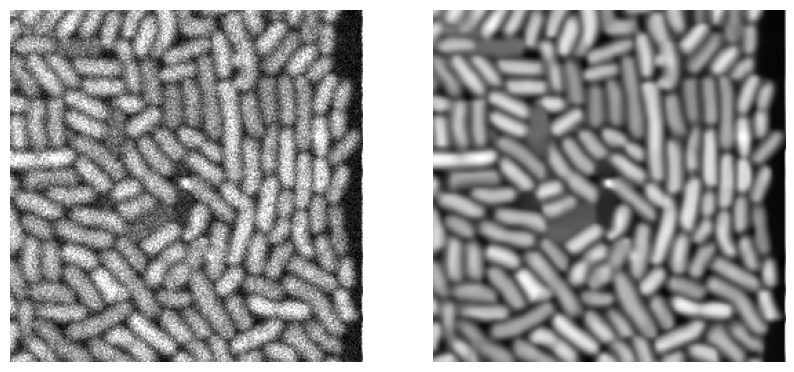

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(image, cmap='gray')
axes[0].axis('off')

axes[1].imshow(img1_denoised, cmap='gray')
axes[1].axis('off')